In [39]:
from utils_experiment import (
    load_data,
    filter_data_exp_1,
    AutoGluonProcessor,
    fit_predictors_local,
    fit_predictors_global,
    get_model_list,
    create_output_directories,
    process_and_plot_forecasts,
)

In [40]:
import torch
print("Is cuda available? {}".format(torch.cuda.is_available()))
torch.cuda.get_device_name(torch.cuda.current_device())

torch.__version__

Is cuda available? True


'2.3.1+cu118'

## Experiment 1 Details

Experiment 1 serves as a baseline for comparing the effect of different window lengths for training. The data will be filtered to include only time series that are available in the time period. To investiage the effect of the time series by themselves, the number of covariates is kept constant across all time series and corresponds to the time series fully available from 1986. The specific time periods were chosen with the condition that between each interval, 5 or more new time series were introduced.

| Time Period - 2024     | Maximum number of covariates | Number of covariates used |
|--------------|:-----:| :-----:| 
| 1986 |   94  |   94  |  
| 1997 |   111  |  94  |  
| 2004 |   133  |   94  |  
| 2007 |   146  |  94  |  
| 2010 |   154  |  94  |  
| 2018 |   159  |  94  |  


The cut-off dates are set at 4 yearly intervals between 2020 and 2024. Since the minimum training length for a yearly interval is 2 years, 2020 is the earliest cut-off date we can use.


In [41]:
exp_test_description = "LLMP_comparison"
report_sim_dates = open("experiment_cutoff_dates_LLMP_futureregressors.txt", 'r').read().split()
report_sim_dates = report_sim_dates[:4]

target_categories=['Meat', 
                   'Vegetables and vegetable preparations', 
                   'Bakery and cereal products (excluding baby food)'
                  ]
target_categories = [f"food_cpi: {col}" for col in target_categories]

start_year = 1986
random_seed = 42

print("Target Categories:\n" + '\n'.join(target_categories))
print("Report Simulation Dates:\n" + '\n'.join(report_sim_dates))


Target Categories:
food_cpi: Meat
food_cpi: Vegetables and vegetable preparations
food_cpi: Bakery and cereal products (excluding baby food)
Report Simulation Dates:
2009-07-01
2010-07-01
2011-07-01
2012-07-01


## Load data

`all_data`: dataframe with all the food cpi variables and all the covariates from 1986 to 2024.\
`foodprice_df`: dataframe with only the food cpi variables from 1986 to 2024.\
`target_categories`: list of the names of the food cpi variables.\
`all_covariates`: dataframe with all the covariates from 1986 to 2024.

In [42]:
file_path = "../data/processed_data/all_data_processed.csv"
all_data, foodprice_df, target_categories, all_covariates = load_data(target_categories, file_path)

In [43]:
foodprice_df

,food_cpi: Meat,food_cpi: Vegetables and vegetable preparations,food_cpi: Bakery and cereal products (excluding baby food)
1986-01-01,65.1,76.0,69.3
1986-02-01,64.2,68.4,70.3
1986-03-01,64.2,66.2,70.6
1986-04-01,63.6,71.1,71.3
1986-05-01,64.0,75.3,71.2
...,...,...,...
2024-05-01,210.2,189.7,198.8
2024-06-01,211.3,190.2,198.2
2024-07-01,212.8,194.7,199.1
2024-08-01,212.5,189.8,198.4


In [44]:
all_data = filter_data_exp_1(all_data, start_year)
processor = AutoGluonProcessor(all_data, target_categories)


# Experiment List

| AutoGluon Model \ Experiment      | local | global | global + covariates |
|--------------|:-----:| :-----: | :-----: |
| NaiveModel |   x  |   |  | 
| SeasonalNaiveModel|   x    |  |  | 
| AutoARIMAModel|   x   |  |  | 
| AutoETSModel|  x  |    |  | 
| DeepARModel|  x   | x |  x | 
| DLinearModel| x   | x |  x| 
| PatchTSTModel|  x   | x | x |   
|SimpleFeedForwardModel|  x   | x | x |   
| TemporalFusionTransformerModel| x  | x | x |   
| DirectTabularModel| x   | x | x | 
|RecursiveTabularModel|  x   | x | x |  
|ChronosModel|  x   | x | x | 

x - model type supported


## Main experiment loop - local models

4 main loops:
- The first loop goes through the list of years at which we want the time window to start, filters out the covariates that are not fully available from 1986.
- The second loop goes though each of the 12 Autogluon models.
- The third loop goes through each of the yearly cut-off dates to trim the training data.
- The fourth loop goes through each of the 9 food categories, gets the training data in the AutoGluon format for local models and plot each prediction period againt the actual values.

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_SeasonalNaiveModel/random_seed_42/2009-07-01/model_files//food_cpi: Meat/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       163.04 GB / 188.59 GB (86.5%)
Disk Space Avail:   17600.14 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'SeasonalNaiveModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 1800,
 'verbosity': 2

SeasonalNaiveModel


	-0.0364       = Validation score (-MAPE)
	0.02    s     = Training runtime
	3.24    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['SeasonalNaive']
Total runtime: 3.28 s
Best model: SeasonalNaive
Best model score: -0.0364
Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


****************** Summary of fit() ******************
Estimated performance of each model:
           model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SeasonalNaive  -0.036377       3.242204           0.021114          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


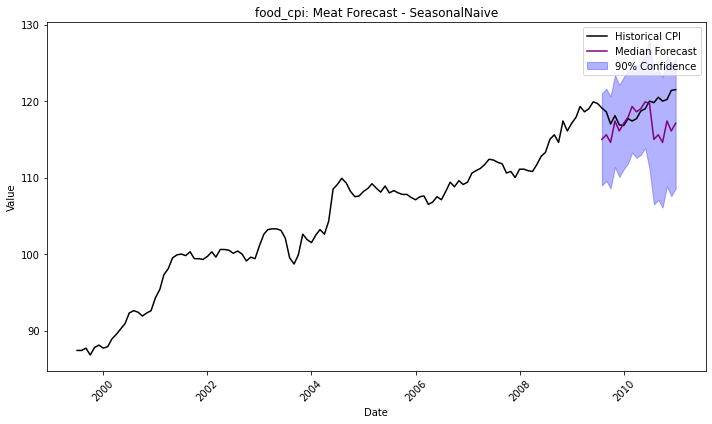

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_SeasonalNaiveModel/random_seed_42/2009-07-01/model_files//food_cpi: Vegetables and vegetable preparations/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       162.44 GB / 188.59 GB (86.1%)
Disk Space Avail:   17600.14 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'SeasonalNaiveModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 't

SeasonalNaiveModel


	-0.1034       = Validation score (-MAPE)
	0.02    s     = Training runtime
	1.15    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['SeasonalNaive']
Total runtime: 1.19 s
Best model: SeasonalNaive
Best model score: -0.1034
Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


****************** Summary of fit() ******************
Estimated performance of each model:
           model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SeasonalNaive  -0.103401       1.147285           0.021057          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


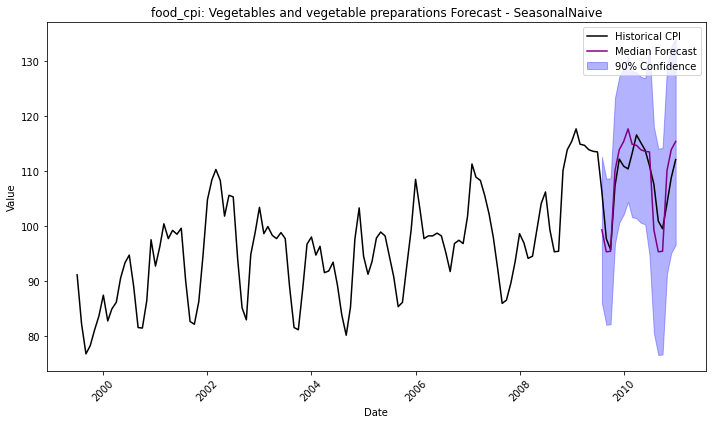

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_SeasonalNaiveModel/random_seed_42/2009-07-01/model_files//food_cpi: Bakery and cereal products (excluding baby food)/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       162.30 GB / 188.59 GB (86.1%)
Disk Space Avail:   17600.14 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'SeasonalNaiveModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 't

SeasonalNaiveModel


	-0.1222       = Validation score (-MAPE)
	0.02    s     = Training runtime
	1.17    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['SeasonalNaive']
Total runtime: 1.20 s
Best model: SeasonalNaive
Best model score: -0.1222
Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


****************** Summary of fit() ******************
Estimated performance of each model:
           model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SeasonalNaive  -0.122248       1.173469            0.01845          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


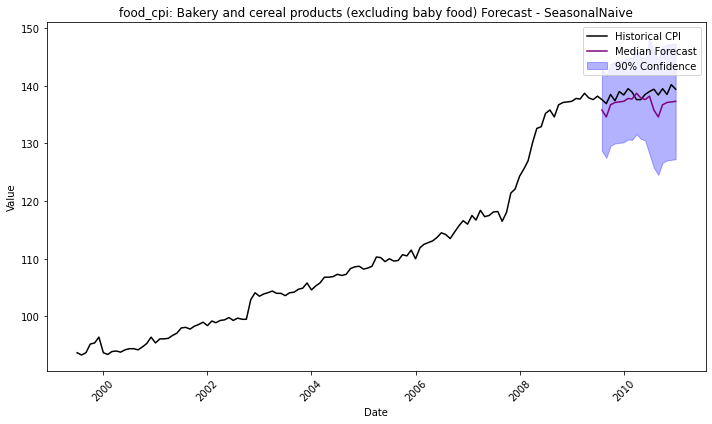

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_SeasonalNaiveModel/random_seed_42/2010-07-01/model_files//food_cpi: Meat/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       162.16 GB / 188.59 GB (86.0%)
Disk Space Avail:   17600.13 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'SeasonalNaiveModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 1800,
 'verbosity': 2

SeasonalNaiveModel


	-0.0445       = Validation score (-MAPE)
	0.02    s     = Training runtime
	1.15    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['SeasonalNaive']
Total runtime: 1.18 s
Best model: SeasonalNaive
Best model score: -0.0445
Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


****************** Summary of fit() ******************
Estimated performance of each model:
           model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SeasonalNaive  -0.044468       1.145245           0.019776          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


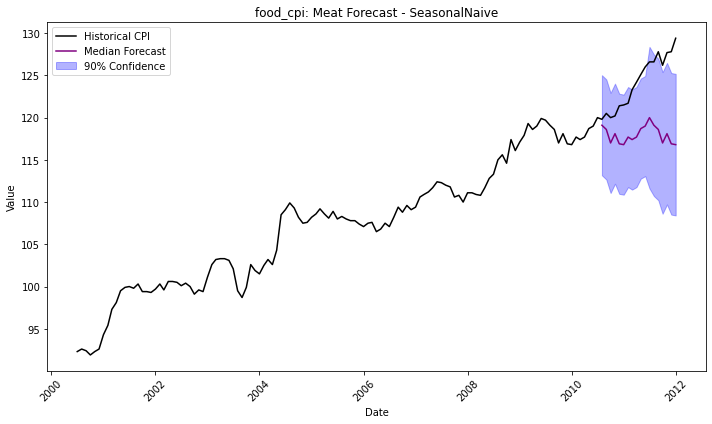

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_SeasonalNaiveModel/random_seed_42/2010-07-01/model_files//food_cpi: Vegetables and vegetable preparations/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       162.02 GB / 188.59 GB (85.9%)
Disk Space Avail:   17600.13 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'SeasonalNaiveModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 't

SeasonalNaiveModel


	-0.0963       = Validation score (-MAPE)
	0.02    s     = Training runtime
	1.17    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['SeasonalNaive']
Total runtime: 1.21 s
Best model: SeasonalNaive
Best model score: -0.0963
Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


****************** Summary of fit() ******************
Estimated performance of each model:
           model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SeasonalNaive  -0.096293       1.173924           0.019252          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


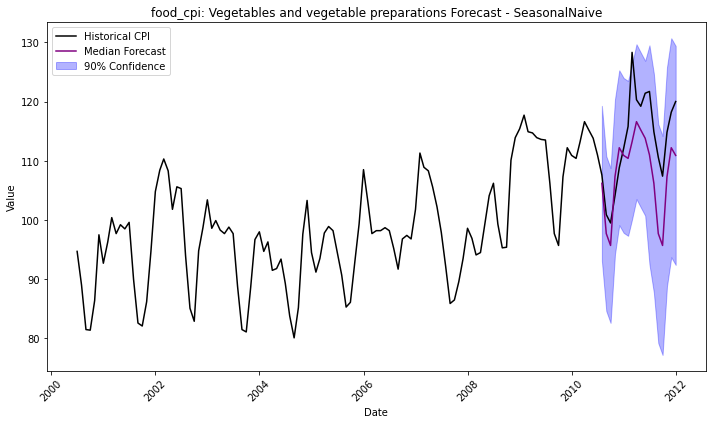

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_SeasonalNaiveModel/random_seed_42/2010-07-01/model_files//food_cpi: Bakery and cereal products (excluding baby food)/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       161.87 GB / 188.59 GB (85.8%)
Disk Space Avail:   17600.12 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'SeasonalNaiveModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 't

SeasonalNaiveModel


	-0.0407       = Validation score (-MAPE)
	0.02    s     = Training runtime
	1.15    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['SeasonalNaive']
Total runtime: 1.19 s
Best model: SeasonalNaive
Best model score: -0.0407
Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


****************** Summary of fit() ******************
Estimated performance of each model:
           model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SeasonalNaive  -0.040691        1.14743           0.020519          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


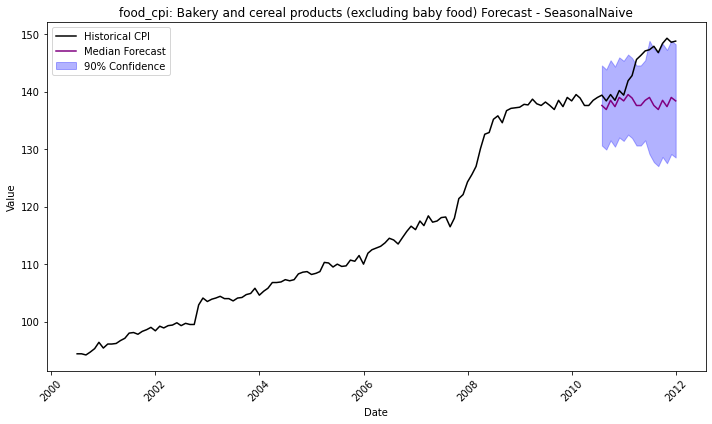

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_SeasonalNaiveModel/random_seed_42/2011-07-01/model_files//food_cpi: Meat/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       161.73 GB / 188.59 GB (85.8%)
Disk Space Avail:   17600.12 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'SeasonalNaiveModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 1800,
 'verbosity': 2

SeasonalNaiveModel


	-0.0244       = Validation score (-MAPE)
	0.02    s     = Training runtime
	1.14    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['SeasonalNaive']
Total runtime: 1.18 s
Best model: SeasonalNaive
Best model score: -0.0244
Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


****************** Summary of fit() ******************
Estimated performance of each model:
           model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SeasonalNaive  -0.024355       1.143635           0.020797          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


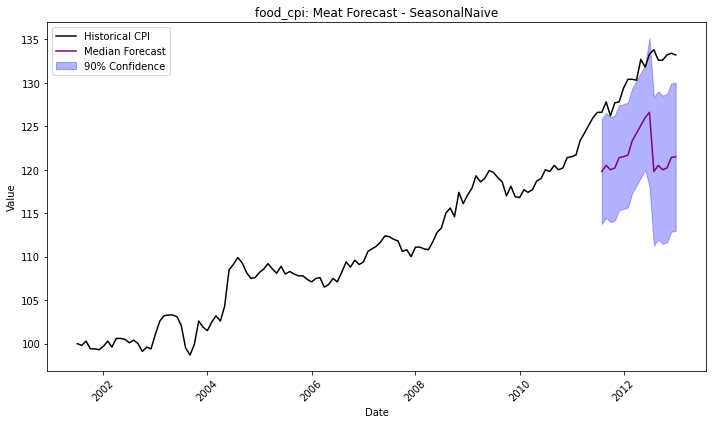

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_SeasonalNaiveModel/random_seed_42/2011-07-01/model_files//food_cpi: Vegetables and vegetable preparations/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       161.59 GB / 188.59 GB (85.7%)
Disk Space Avail:   17600.12 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'SeasonalNaiveModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 't

SeasonalNaiveModel


	-0.0351       = Validation score (-MAPE)
	0.02    s     = Training runtime
	1.13    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['SeasonalNaive']
Total runtime: 1.17 s
Best model: SeasonalNaive
Best model score: -0.0351
Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


****************** Summary of fit() ******************
Estimated performance of each model:
           model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SeasonalNaive  -0.035117       1.128359           0.022071          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


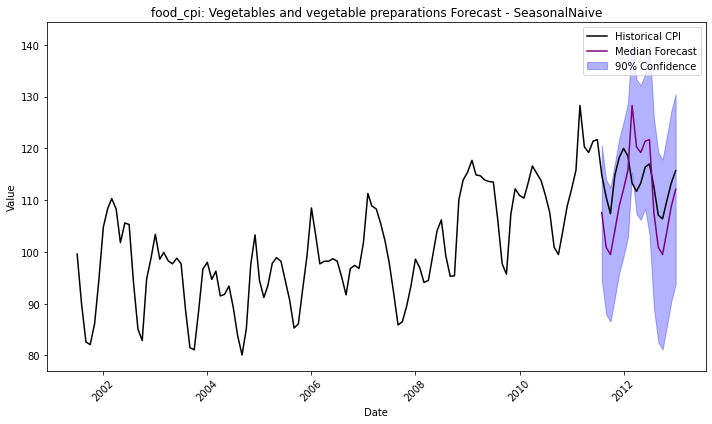

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_SeasonalNaiveModel/random_seed_42/2011-07-01/model_files//food_cpi: Bakery and cereal products (excluding baby food)/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       161.45 GB / 188.59 GB (85.6%)
Disk Space Avail:   17600.12 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'SeasonalNaiveModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 't

SeasonalNaiveModel
****************** Summary of fit() ******************
Estimated performance of each model:
           model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SeasonalNaive  -0.021868       0.023503           0.018379          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


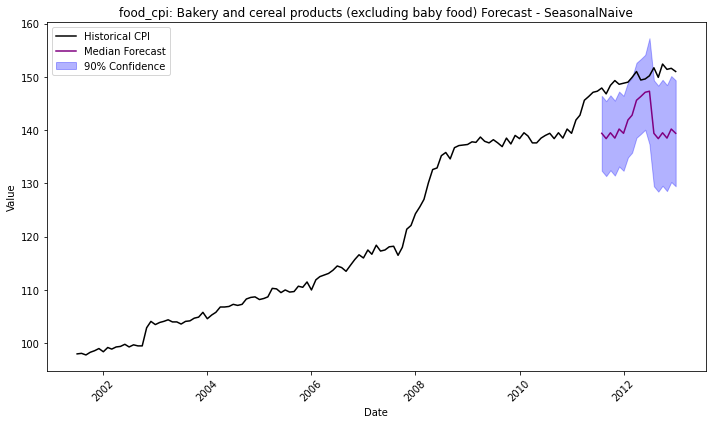

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_SeasonalNaiveModel/random_seed_42/2012-07-01/model_files//food_cpi: Meat/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       161.45 GB / 188.59 GB (85.6%)
Disk Space Avail:   17600.12 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'SeasonalNaiveModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 1800,
 'verbosity': 2

SeasonalNaiveModel
****************** Summary of fit() ******************
Estimated performance of each model:
           model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SeasonalNaive  -0.067661       0.020302           0.019226          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


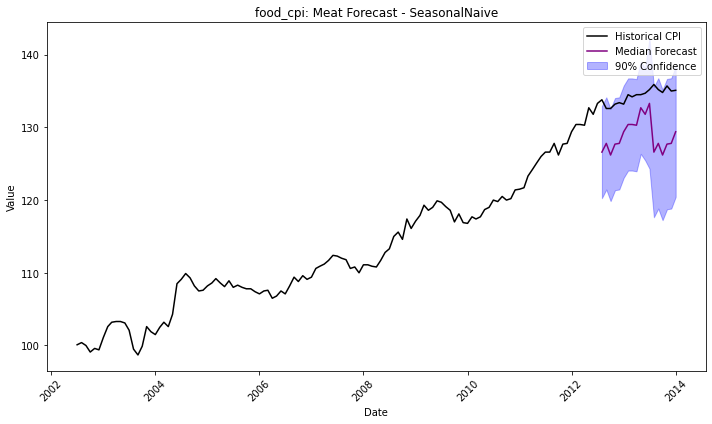

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_SeasonalNaiveModel/random_seed_42/2012-07-01/model_files//food_cpi: Vegetables and vegetable preparations/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       161.45 GB / 188.59 GB (85.6%)
Disk Space Avail:   17600.12 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'SeasonalNaiveModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 't

SeasonalNaiveModel
****************** Summary of fit() ******************
Estimated performance of each model:
           model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SeasonalNaive  -0.058112       0.023015            0.01714          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


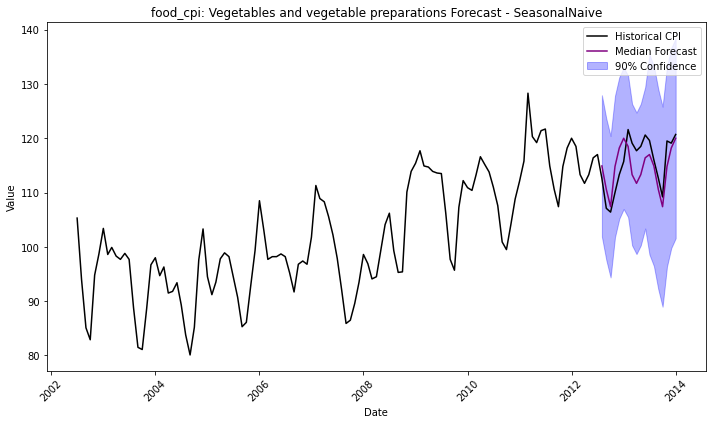

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_SeasonalNaiveModel/random_seed_42/2012-07-01/model_files//food_cpi: Bakery and cereal products (excluding baby food)/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       161.45 GB / 188.59 GB (85.6%)
Disk Space Avail:   17600.12 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'SeasonalNaiveModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 't

SeasonalNaiveModel
****************** Summary of fit() ******************
Estimated performance of each model:
           model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SeasonalNaive  -0.060766       0.022925           0.020319          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


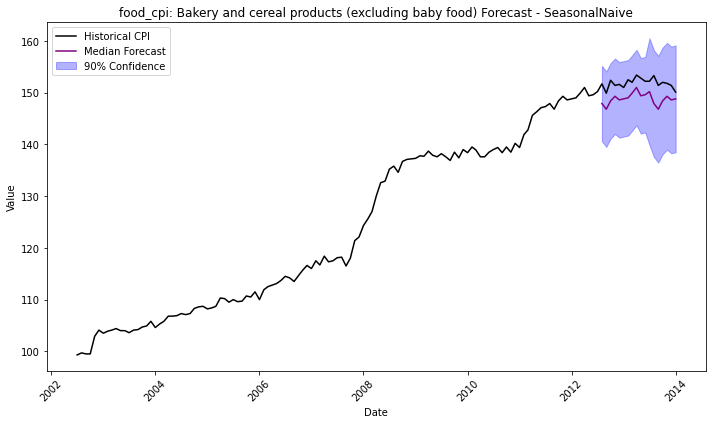

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_AutoETSModel/random_seed_42/2009-07-01/model_files//food_cpi: Meat/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       161.45 GB / 188.59 GB (85.6%)
Disk Space Avail:   17600.12 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'AutoETSModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 1800,
 'verbosity': 2}

Inferred 

AutoETSModel


	-0.0257       = Validation score (-MAPE)
	0.02    s     = Training runtime
	21.74   s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['AutoETS']
Total runtime: 21.77 s
Best model: AutoETS
Best model score: -0.0257
Model not specified in predict, will default to the model with the best validation score: AutoETS


****************** Summary of fit() ******************
Estimated performance of each model:
     model  score_val  pred_time_val  fit_time_marginal  fit_order
0  AutoETS  -0.025703      21.740776           0.018645          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: AutoETS


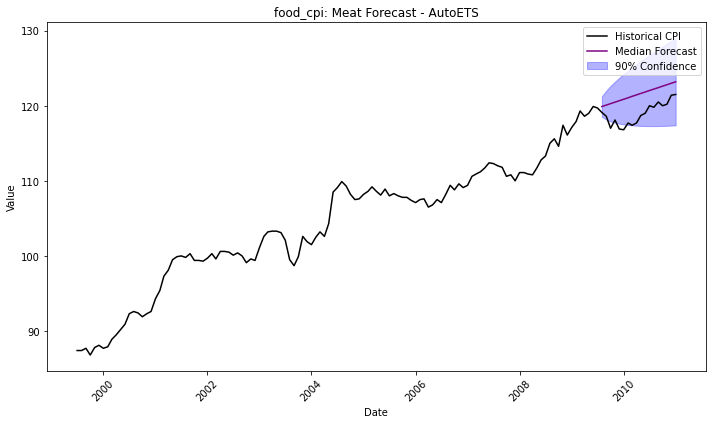

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_AutoETSModel/random_seed_42/2009-07-01/model_files//food_cpi: Vegetables and vegetable preparations/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       161.13 GB / 188.59 GB (85.4%)
Disk Space Avail:   17572.51 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'AutoETSModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 

AutoETSModel


	-0.1077       = Validation score (-MAPE)
	0.02    s     = Training runtime
	22.00   s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['AutoETS']
Total runtime: 22.04 s
Best model: AutoETS
Best model score: -0.1077
Model not specified in predict, will default to the model with the best validation score: AutoETS


****************** Summary of fit() ******************
Estimated performance of each model:
     model  score_val  pred_time_val  fit_time_marginal  fit_order
0  AutoETS  -0.107716      21.997154           0.019483          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: AutoETS


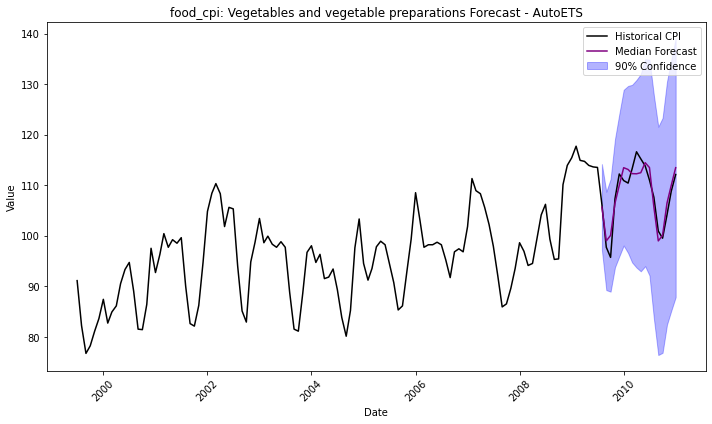

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_AutoETSModel/random_seed_42/2009-07-01/model_files//food_cpi: Bakery and cereal products (excluding baby food)/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       160.79 GB / 188.59 GB (85.3%)
Disk Space Avail:   17572.57 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'AutoETSModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'ti

AutoETSModel


	-0.0667       = Validation score (-MAPE)
	0.02    s     = Training runtime
	22.00   s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['AutoETS']
Total runtime: 22.03 s
Best model: AutoETS
Best model score: -0.0667
Model not specified in predict, will default to the model with the best validation score: AutoETS


****************** Summary of fit() ******************
Estimated performance of each model:
     model  score_val  pred_time_val  fit_time_marginal  fit_order
0  AutoETS  -0.066734      22.001558           0.018998          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: AutoETS


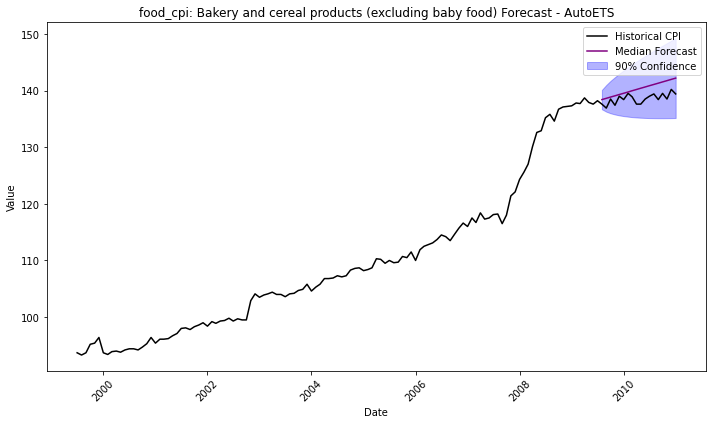

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_AutoETSModel/random_seed_42/2010-07-01/model_files//food_cpi: Meat/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       160.46 GB / 188.59 GB (85.1%)
Disk Space Avail:   17559.72 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'AutoETSModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 1800,
 'verbosity': 2}

Inferred 

AutoETSModel


	-0.0120       = Validation score (-MAPE)
	0.02    s     = Training runtime
	21.50   s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['AutoETS']
Total runtime: 21.54 s
Best model: AutoETS
Best model score: -0.0120
Model not specified in predict, will default to the model with the best validation score: AutoETS


****************** Summary of fit() ******************
Estimated performance of each model:
     model  score_val  pred_time_val  fit_time_marginal  fit_order
0  AutoETS  -0.012049      21.502519           0.020889          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: AutoETS


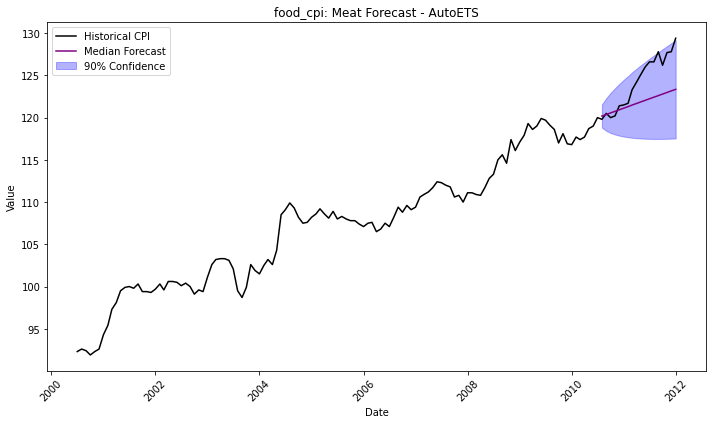

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_AutoETSModel/random_seed_42/2010-07-01/model_files//food_cpi: Vegetables and vegetable preparations/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       160.13 GB / 188.59 GB (84.9%)
Disk Space Avail:   17539.25 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'AutoETSModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 

AutoETSModel


	-0.0226       = Validation score (-MAPE)
	0.02    s     = Training runtime
	21.68   s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['AutoETS']
Total runtime: 21.72 s
Best model: AutoETS
Best model score: -0.0226
Model not specified in predict, will default to the model with the best validation score: AutoETS


****************** Summary of fit() ******************
Estimated performance of each model:
     model  score_val  pred_time_val  fit_time_marginal  fit_order
0  AutoETS  -0.022587      21.680229             0.0207          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: AutoETS


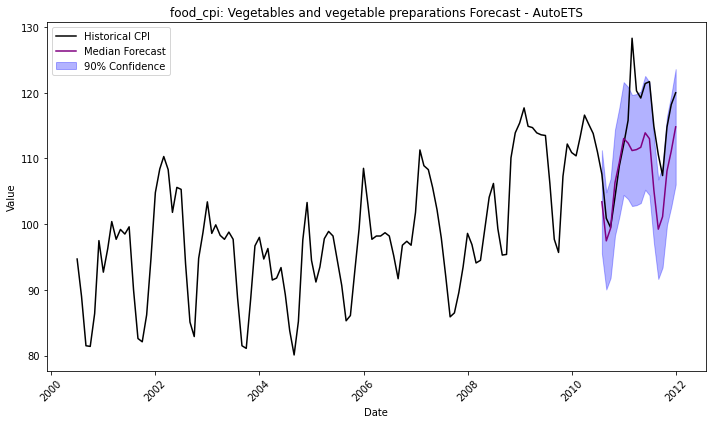

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_AutoETSModel/random_seed_42/2010-07-01/model_files//food_cpi: Bakery and cereal products (excluding baby food)/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       159.80 GB / 188.59 GB (84.7%)
Disk Space Avail:   17539.27 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'AutoETSModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'ti

AutoETSModel


	-0.0100       = Validation score (-MAPE)
	0.02    s     = Training runtime
	22.06   s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['AutoETS']
Total runtime: 22.09 s
Best model: AutoETS
Best model score: -0.0100
Model not specified in predict, will default to the model with the best validation score: AutoETS


****************** Summary of fit() ******************
Estimated performance of each model:
     model  score_val  pred_time_val  fit_time_marginal  fit_order
0  AutoETS   -0.01003      22.058252           0.018232          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: AutoETS


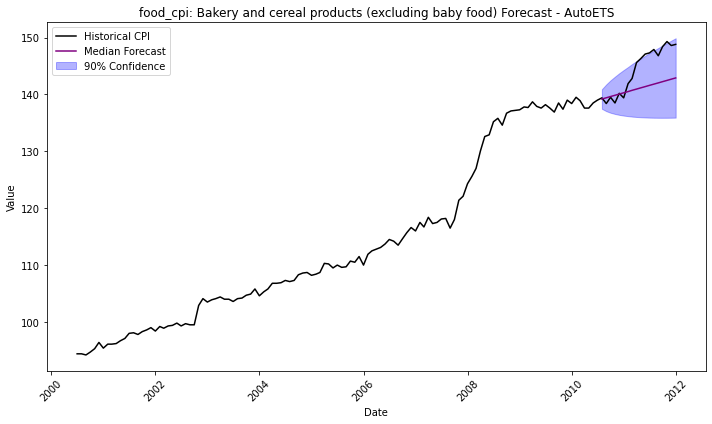

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_AutoETSModel/random_seed_42/2011-07-01/model_files//food_cpi: Meat/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       159.45 GB / 188.59 GB (84.6%)
Disk Space Avail:   17532.18 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'AutoETSModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 1800,
 'verbosity': 2}

Inferred 

AutoETSModel


	-0.0216       = Validation score (-MAPE)
	0.02    s     = Training runtime
	21.98   s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['AutoETS']
Total runtime: 22.02 s
Best model: AutoETS
Best model score: -0.0216
Model not specified in predict, will default to the model with the best validation score: AutoETS


****************** Summary of fit() ******************
Estimated performance of each model:
     model  score_val  pred_time_val  fit_time_marginal  fit_order
0  AutoETS  -0.021554      21.983918           0.017632          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: AutoETS


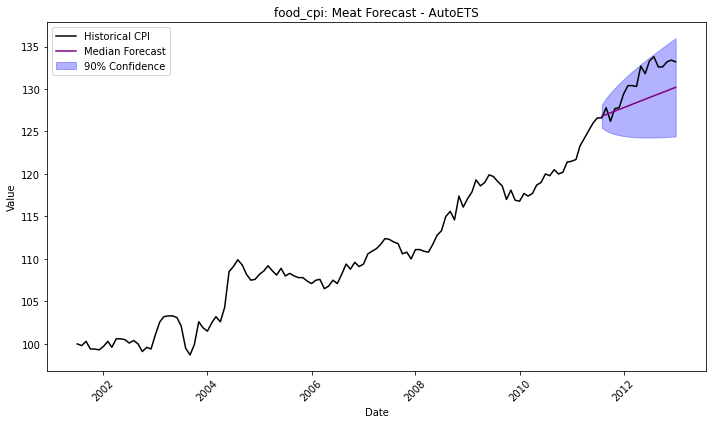

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_AutoETSModel/random_seed_42/2011-07-01/model_files//food_cpi: Vegetables and vegetable preparations/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       159.32 GB / 188.59 GB (84.5%)
Disk Space Avail:   17516.36 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'AutoETSModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 

AutoETSModel


	-0.0312       = Validation score (-MAPE)
	0.02    s     = Training runtime
	1.27    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['AutoETS']
Total runtime: 1.30 s
Best model: AutoETS
Best model score: -0.0312
Model not specified in predict, will default to the model with the best validation score: AutoETS


****************** Summary of fit() ******************
Estimated performance of each model:
     model  score_val  pred_time_val  fit_time_marginal  fit_order
0  AutoETS  -0.031242       1.268531           0.019448          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: AutoETS


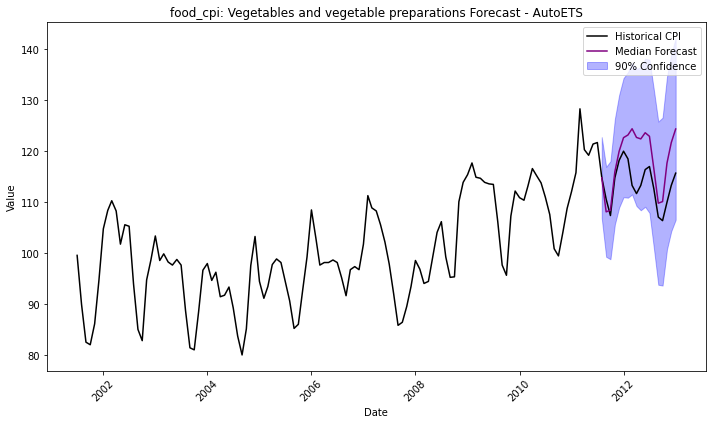

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_AutoETSModel/random_seed_42/2011-07-01/model_files//food_cpi: Bakery and cereal products (excluding baby food)/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       159.27 GB / 188.59 GB (84.5%)
Disk Space Avail:   17516.36 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'AutoETSModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'ti

AutoETSModel


	-0.0130       = Validation score (-MAPE)
	0.02    s     = Training runtime
	0.66    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['AutoETS']
Total runtime: 0.69 s
Best model: AutoETS
Best model score: -0.0130
Model not specified in predict, will default to the model with the best validation score: AutoETS


****************** Summary of fit() ******************
Estimated performance of each model:
     model  score_val  pred_time_val  fit_time_marginal  fit_order
0  AutoETS  -0.013045       0.658678           0.018076          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: AutoETS


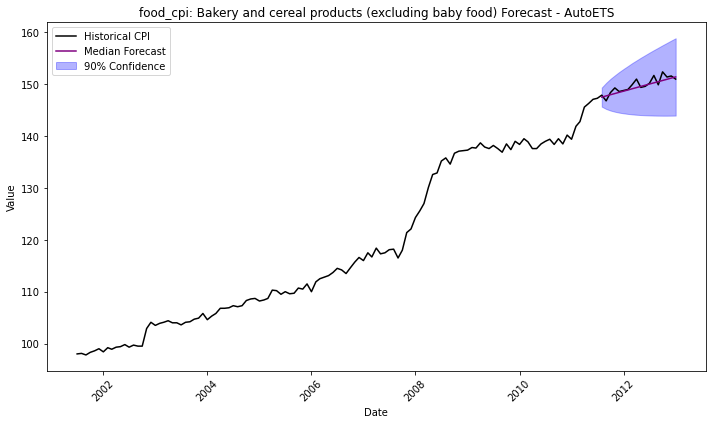

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_AutoETSModel/random_seed_42/2012-07-01/model_files//food_cpi: Meat/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       159.26 GB / 188.59 GB (84.4%)
Disk Space Avail:   17516.35 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'AutoETSModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 1800,
 'verbosity': 2}

Inferred 

AutoETSModel


	-0.0353       = Validation score (-MAPE)
	0.02    s     = Training runtime
	0.70    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['AutoETS']
Total runtime: 0.73 s
Best model: AutoETS
Best model score: -0.0353
Model not specified in predict, will default to the model with the best validation score: AutoETS


****************** Summary of fit() ******************
Estimated performance of each model:
     model  score_val  pred_time_val  fit_time_marginal  fit_order
0  AutoETS  -0.035302       0.699152           0.018655          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: AutoETS


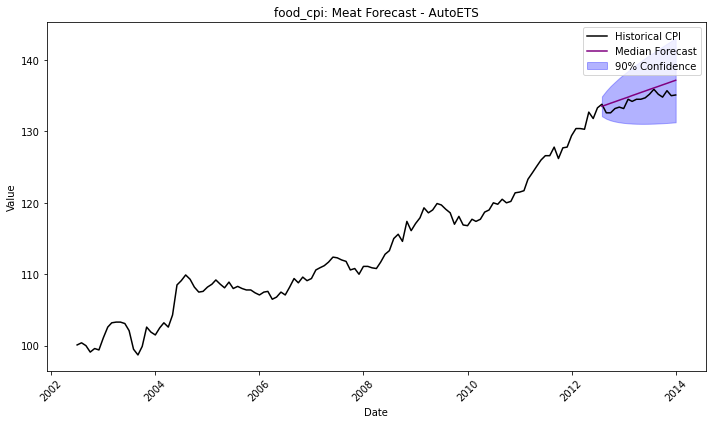

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_AutoETSModel/random_seed_42/2012-07-01/model_files//food_cpi: Vegetables and vegetable preparations/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       159.26 GB / 188.59 GB (84.4%)
Disk Space Avail:   17516.35 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'AutoETSModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 

AutoETSModel


	-0.0523       = Validation score (-MAPE)
	0.02    s     = Training runtime
	1.10    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['AutoETS']
Total runtime: 1.13 s
Best model: AutoETS
Best model score: -0.0523
Model not specified in predict, will default to the model with the best validation score: AutoETS


****************** Summary of fit() ******************
Estimated performance of each model:
     model  score_val  pred_time_val  fit_time_marginal  fit_order
0  AutoETS  -0.052297       1.099812           0.019131          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: AutoETS


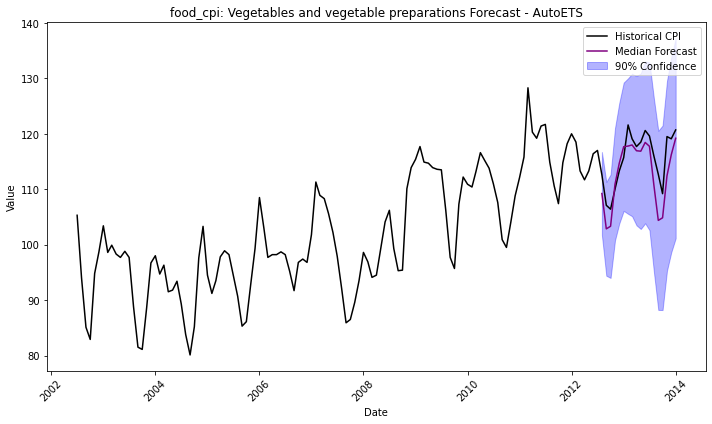

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_local_AutoETSModel/random_seed_42/2012-07-01/model_files//food_cpi: Bakery and cereal products (excluding baby food)/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       159.26 GB / 188.59 GB (84.4%)
Disk Space Avail:   17516.34 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'AutoETSModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'ti

AutoETSModel


	-0.0422       = Validation score (-MAPE)
	0.02    s     = Training runtime
	1.13    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['AutoETS']
Total runtime: 1.17 s
Best model: AutoETS
Best model score: -0.0422
Model not specified in predict, will default to the model with the best validation score: AutoETS


****************** Summary of fit() ******************
Estimated performance of each model:
     model  score_val  pred_time_val  fit_time_marginal  fit_order
0  AutoETS  -0.042196       1.133249           0.021867          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: AutoETS


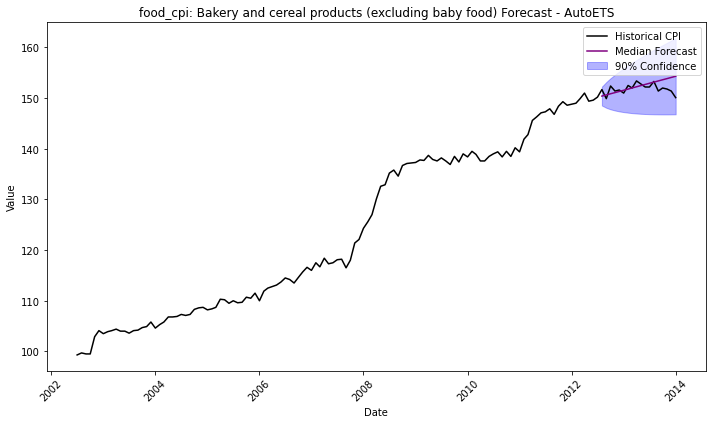

In [45]:
EXP_BASE = "ag_local"
# EXP_MODEL_LIST = get_model_list(EXP_BASE)

EXP_MODEL_LIST = ['SeasonalNaiveModel',
                 'AutoETSModel']

for model_type in EXP_MODEL_LIST:
    EXPERIMENT_NAME = f"{EXP_BASE}_{model_type}"

    for cutoff_date in report_sim_dates:
        forecast_output_dir, plot_output_dir, training_output_dir, model_dir = (
            create_output_directories(
                exp_test_description,
                start_year,
                EXPERIMENT_NAME,
                cutoff_date,
                random_seed
            )
        )

        for category in target_categories:
            train_data = processor.get_autogluon_local_df(category, cutoff_date)
            predictor = fit_predictors_local(model_type, model_dir, train_data, category, random_seed)
            process_and_plot_forecasts(
                predictor,
                train_data,
                category,
                training_output_dir,
                forecast_output_dir,
                plot_output_dir,
                foodprice_df,
                cutoff_date
            )

In [46]:
EXP_MODEL_LIST

['SeasonalNaiveModel', 'AutoETSModel']

# Main experiment loop - global models

5 main loops:
- The first loop goes through the list of years at which we want the time window to start, filters out the covariates that are not fully available from 1986.
- The second loop goes though the two experiment base (global and global+covariates)
- The third loop goes though 8 Autogluon models, excluding all statistical models (Naive, SeasonalNaive, AutoArima, AutoETS).
- The fourth loop goes through each of the yearly cut-off dates to trim the training data.
- The fifth loop goes through each of the 9 food categories, gets the training data in the AutoGluon format depending on the experiment base and plot each prediction period againt the actual values.

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_global_all_TemporalFusionTransformerModel/random_seed_42/2009-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       159.26 GB / 188.59 GB (84.4%)
Disk Space Avail:   17516.33 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'TemporalFusionTransformerModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model

['TemporalFusionTransformerModel', 'SimpleFeedForwardModel']
TemporalFusionTransformerModel
TemporalFusionTransformerModel



AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-10-25 21:40:04
Excluded model types: ['DirectTabular', 'RecursiveTabular']
Models that will be trained: ['TemporalFusionTransformer']
Training timeseries model TemporalFusionTransformer. Training for up to 1799.9s of the 1799.9s of remaining time.
	-2.9115       = Validation score (-MAPE)
	282.26  s     = Training runtime
	0.11    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['TemporalFusionTransformer']
Total runtime: 282.41 s
Best model: TemporalFusionTransformer
Best model score: -2.9115
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -2.911476       0.111839         282.262543   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


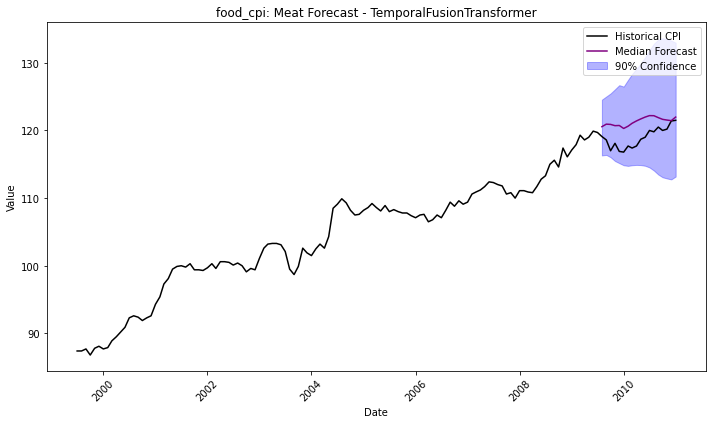

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -2.911476       0.111839         282.262543   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


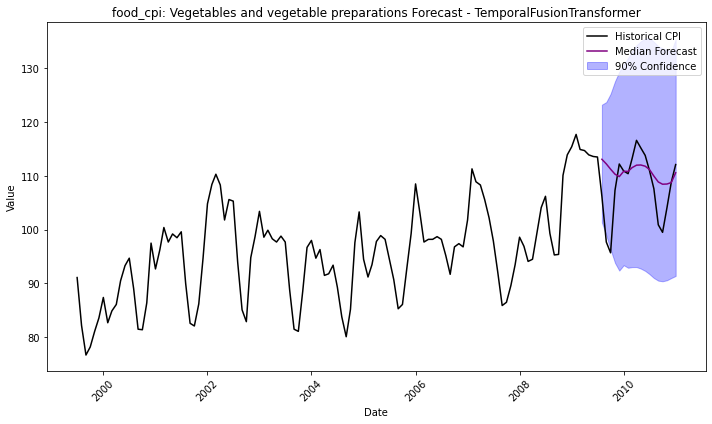

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -2.911476       0.111839         282.262543   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


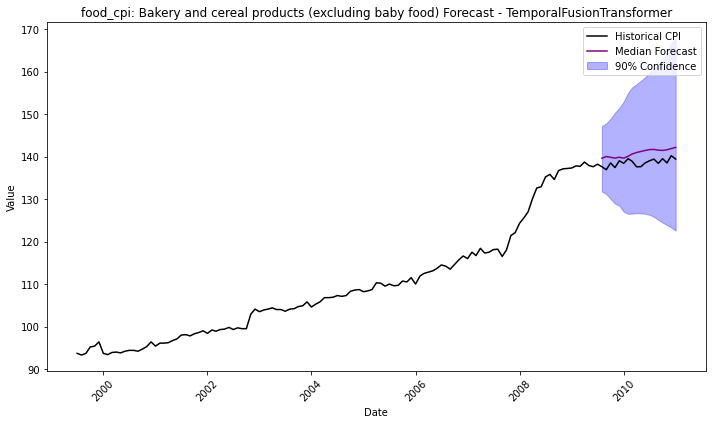

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_global_all_TemporalFusionTransformerModel/random_seed_42/2010-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       160.03 GB / 188.59 GB (84.9%)
Disk Space Avail:   17603.06 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'TemporalFusionTransformerModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model

TemporalFusionTransformerModel



AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-10-25 21:44:48
Excluded model types: ['DirectTabular', 'RecursiveTabular']
Models that will be trained: ['TemporalFusionTransformer']
Training timeseries model TemporalFusionTransformer. Training for up to 1799.9s of the 1799.9s of remaining time.
	-1.8181       = Validation score (-MAPE)
	295.45  s     = Training runtime
	0.10    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['TemporalFusionTransformer']
Total runtime: 295.60 s
Best model: TemporalFusionTransformer
Best model score: -1.8181
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.818094       0.104528         295.453911   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


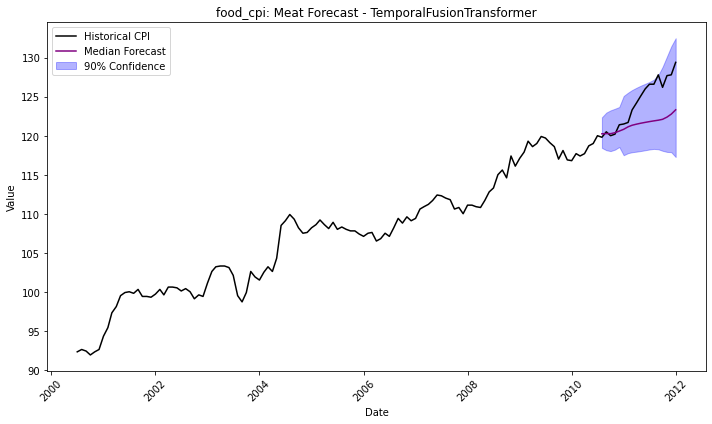

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.818094       0.104528         295.453911   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


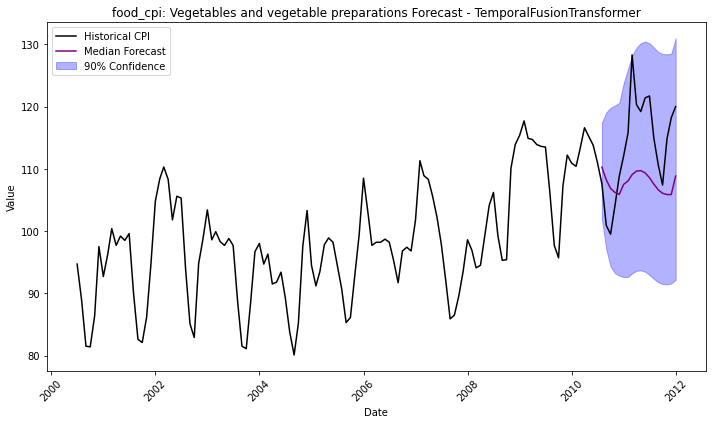

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.818094       0.104528         295.453911   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


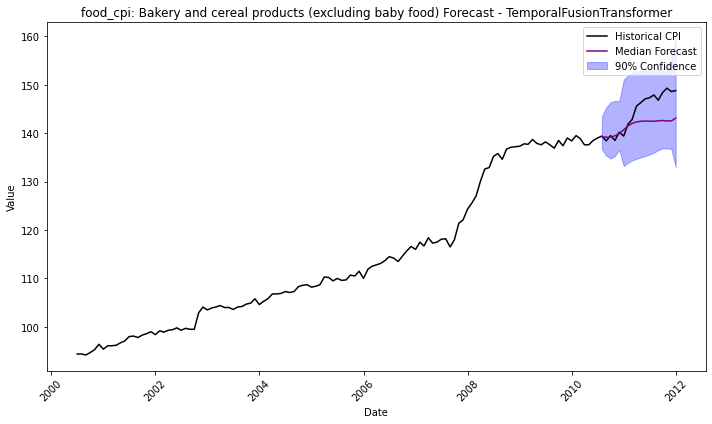

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_global_all_TemporalFusionTransformerModel/random_seed_42/2011-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       163.01 GB / 188.59 GB (86.4%)
Disk Space Avail:   17519.18 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'TemporalFusionTransformerModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model

TemporalFusionTransformerModel



AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-10-25 21:49:46
Excluded model types: ['DirectTabular', 'RecursiveTabular']
Models that will be trained: ['TemporalFusionTransformer']
Training timeseries model TemporalFusionTransformer. Training for up to 1799.9s of the 1799.9s of remaining time.
	-1.9500       = Validation score (-MAPE)
	253.64  s     = Training runtime
	0.11    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['TemporalFusionTransformer']
Total runtime: 253.79 s
Best model: TemporalFusionTransformer
Best model score: -1.9500
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.950044       0.113016         253.636913   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


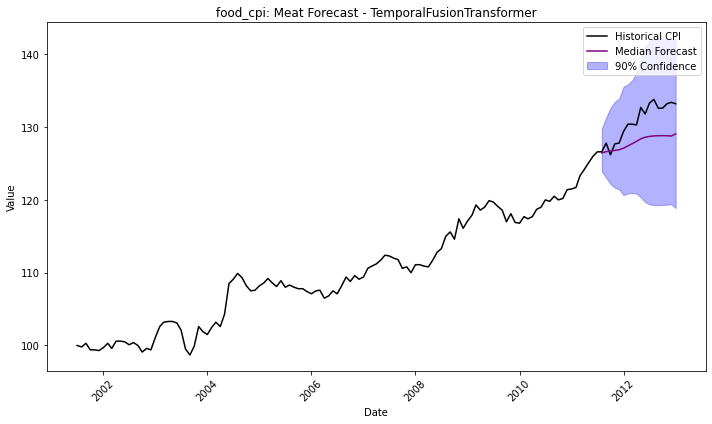

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.950044       0.113016         253.636913   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


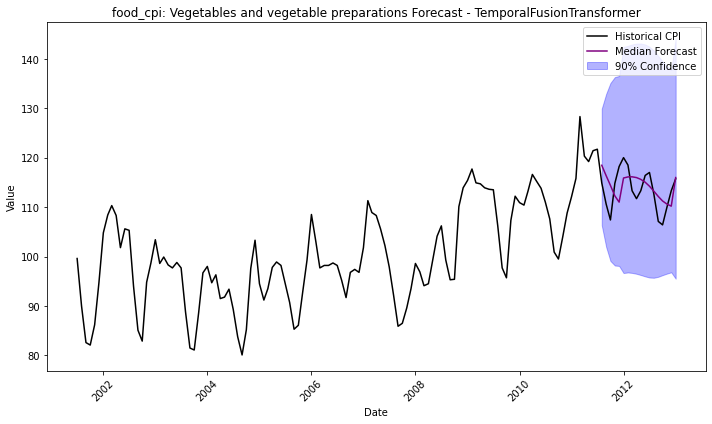

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -1.950044       0.113016         253.636913   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


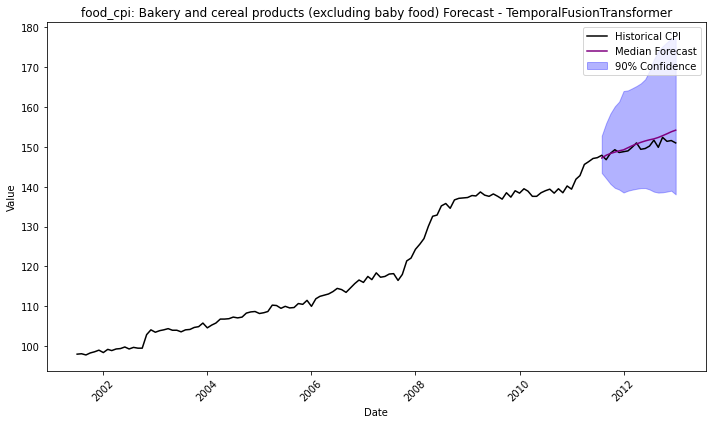

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_global_all_TemporalFusionTransformerModel/random_seed_42/2012-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       162.95 GB / 188.59 GB (86.4%)
Disk Space Avail:   17606.83 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'TemporalFusionTransformerModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model

TemporalFusionTransformerModel



AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-10-25 21:54:02
Excluded model types: ['DirectTabular', 'RecursiveTabular']
Models that will be trained: ['TemporalFusionTransformer']
Training timeseries model TemporalFusionTransformer. Training for up to 1799.8s of the 1799.8s of remaining time.
	-0.9283       = Validation score (-MAPE)
	301.33  s     = Training runtime
	0.12    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['TemporalFusionTransformer']
Total runtime: 301.50 s
Best model: TemporalFusionTransformer
Best model score: -0.9283
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.928328       0.118225         301.330626   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


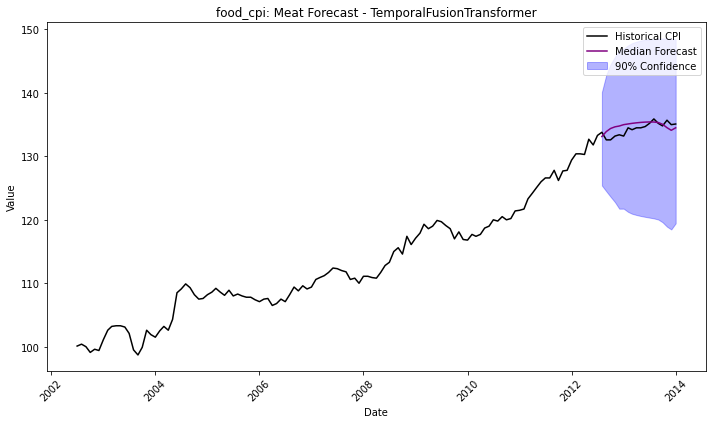

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.928328       0.118225         301.330626   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


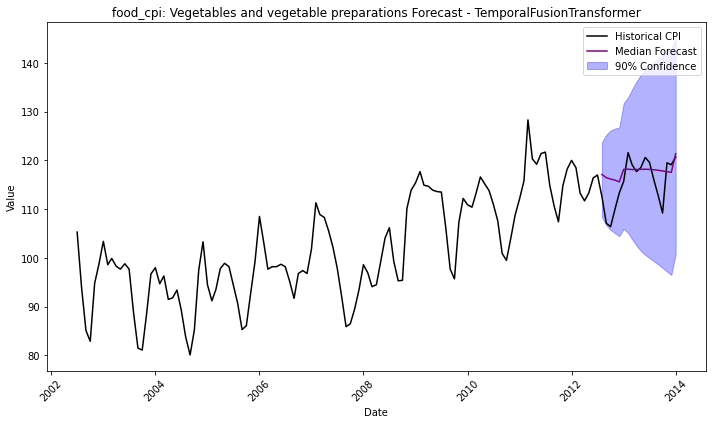

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.928328       0.118225         301.330626   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


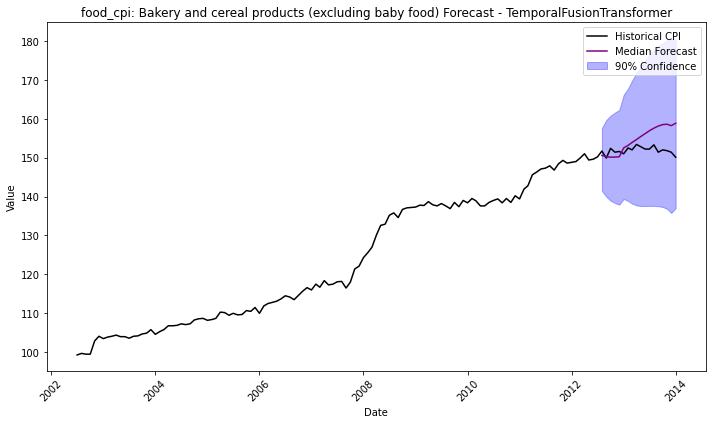

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_global_all_SimpleFeedForwardModel/random_seed_42/2009-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       158.07 GB / 188.59 GB (83.8%)
Disk Space Avail:   17543.88 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'SimpleFeedForwardModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': Fal

SimpleFeedForwardModel
SimpleFeedForwardModel



AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-10-25 21:59:06
Excluded model types: ['DirectTabular', 'RecursiveTabular']
Models that will be trained: ['SimpleFeedForward']
Training timeseries model SimpleFeedForward. Training for up to 1799.9s of the 1799.9s of remaining time.
	-2.5187       = Validation score (-MAPE)
	122.38  s     = Training runtime
	0.13    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['SimpleFeedForward']
Total runtime: 122.54 s
Best model: SimpleFeedForward
Best model score: -2.5187
Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


****************** Summary of fit() ******************
Estimated performance of each model:
               model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SimpleFeedForward  -2.518681       0.132145         122.381468          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


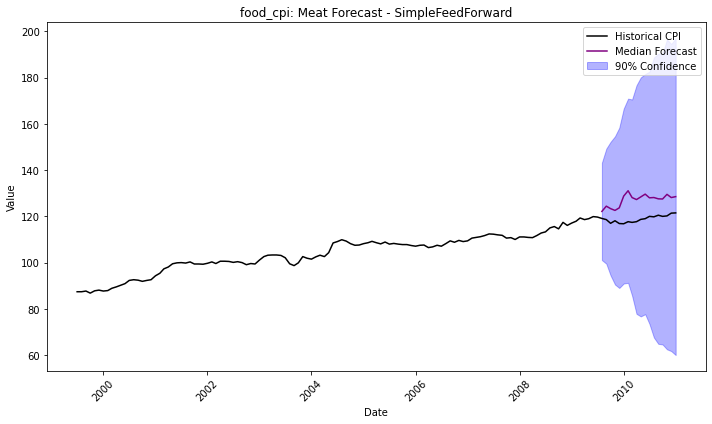

Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


****************** Summary of fit() ******************
Estimated performance of each model:
               model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SimpleFeedForward  -2.518681       0.132145         122.381468          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


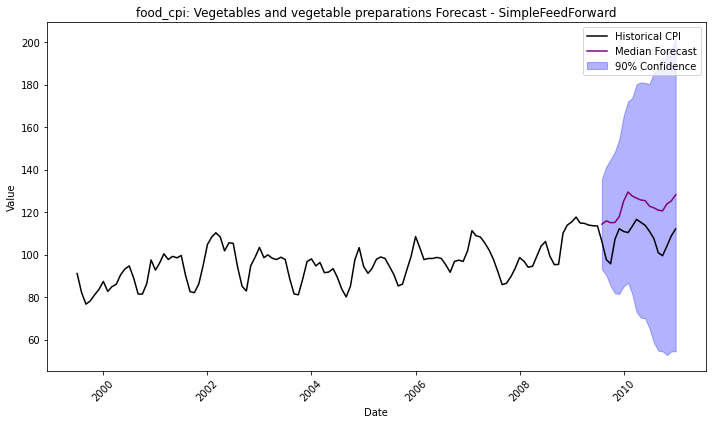

Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


****************** Summary of fit() ******************
Estimated performance of each model:
               model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SimpleFeedForward  -2.518681       0.132145         122.381468          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


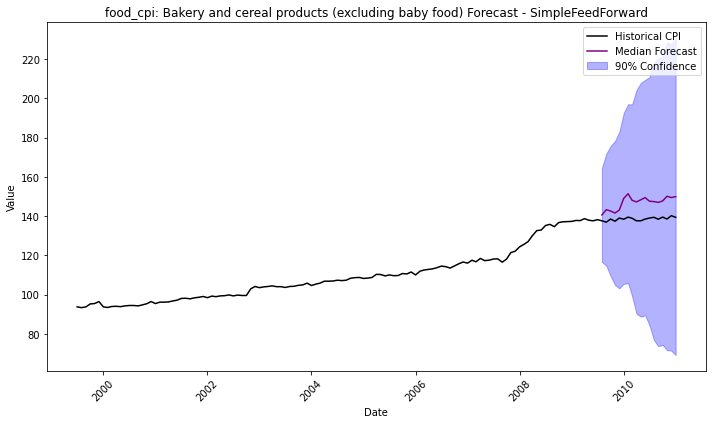

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_global_all_SimpleFeedForwardModel/random_seed_42/2010-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       158.09 GB / 188.59 GB (83.8%)
Disk Space Avail:   17516.64 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'SimpleFeedForwardModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': Fal

SimpleFeedForwardModel



AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-10-25 22:01:11
Excluded model types: ['DirectTabular', 'RecursiveTabular']
Models that will be trained: ['SimpleFeedForward']
Training timeseries model SimpleFeedForward. Training for up to 1799.9s of the 1799.9s of remaining time.
	-1.6785       = Validation score (-MAPE)
	109.00  s     = Training runtime
	0.13    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['SimpleFeedForward']
Total runtime: 109.15 s
Best model: SimpleFeedForward
Best model score: -1.6785
Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


****************** Summary of fit() ******************
Estimated performance of each model:
               model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SimpleFeedForward  -1.678539       0.131039         108.996399          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


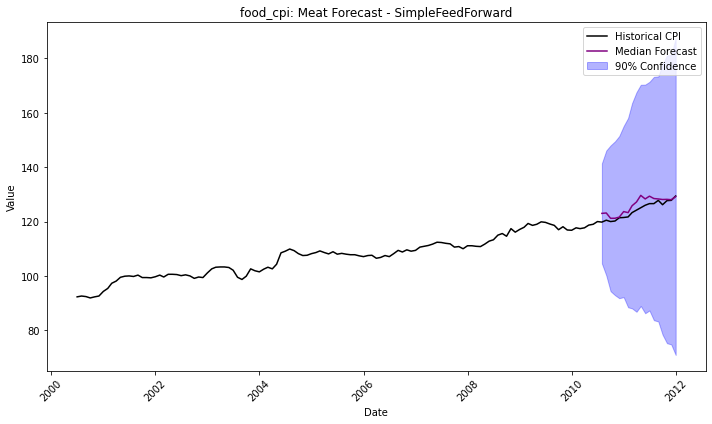

Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


****************** Summary of fit() ******************
Estimated performance of each model:
               model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SimpleFeedForward  -1.678539       0.131039         108.996399          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


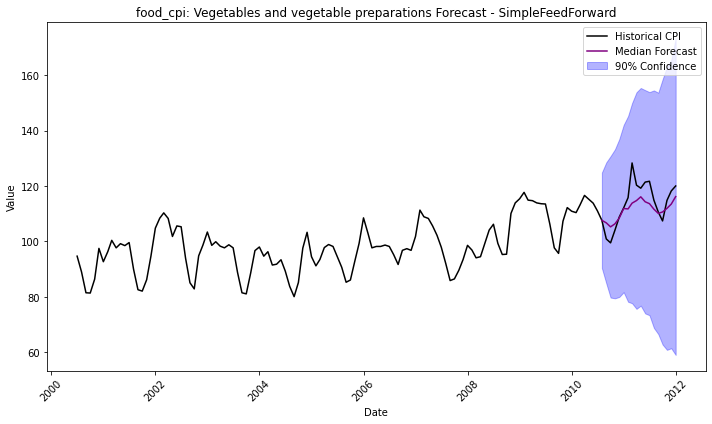

Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


****************** Summary of fit() ******************
Estimated performance of each model:
               model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SimpleFeedForward  -1.678539       0.131039         108.996399          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


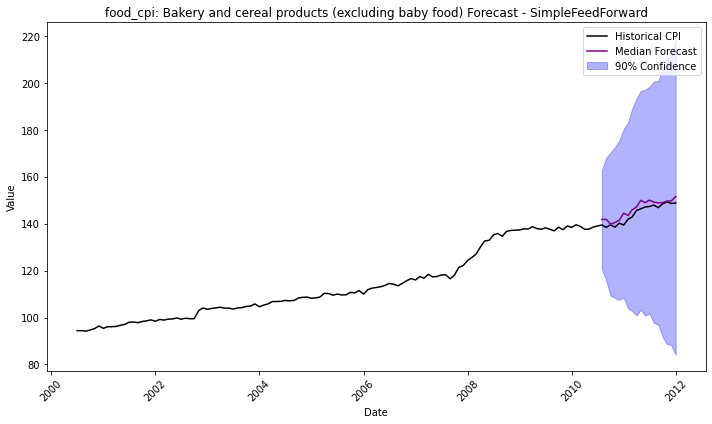

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_global_all_SimpleFeedForwardModel/random_seed_42/2011-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       158.13 GB / 188.59 GB (83.8%)
Disk Space Avail:   17489.94 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'SimpleFeedForwardModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': Fal

SimpleFeedForwardModel



AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-10-25 22:03:02
Excluded model types: ['DirectTabular', 'RecursiveTabular']
Models that will be trained: ['SimpleFeedForward']
Training timeseries model SimpleFeedForward. Training for up to 1799.9s of the 1799.9s of remaining time.
	-1.6683       = Validation score (-MAPE)
	60.00   s     = Training runtime
	0.13    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['SimpleFeedForward']
Total runtime: 60.15 s
Best model: SimpleFeedForward
Best model score: -1.6683
Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


****************** Summary of fit() ******************
Estimated performance of each model:
               model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SimpleFeedForward  -1.668325       0.130955          60.000209          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


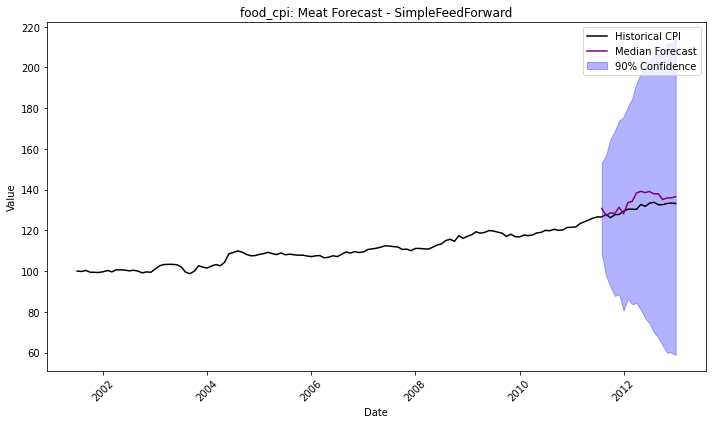

Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


****************** Summary of fit() ******************
Estimated performance of each model:
               model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SimpleFeedForward  -1.668325       0.130955          60.000209          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


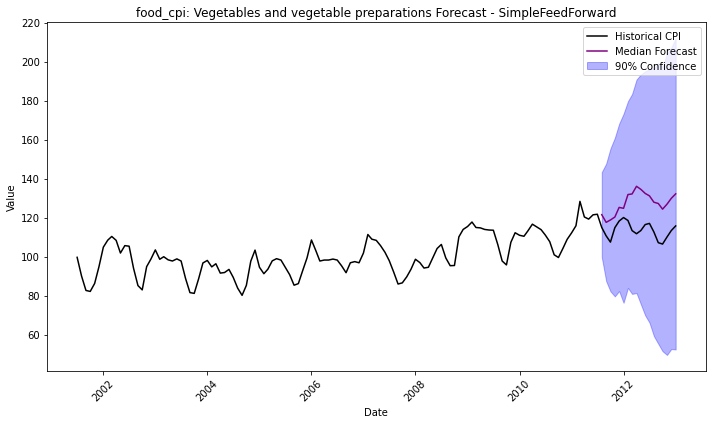

Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


****************** Summary of fit() ******************
Estimated performance of each model:
               model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SimpleFeedForward  -1.668325       0.130955          60.000209          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


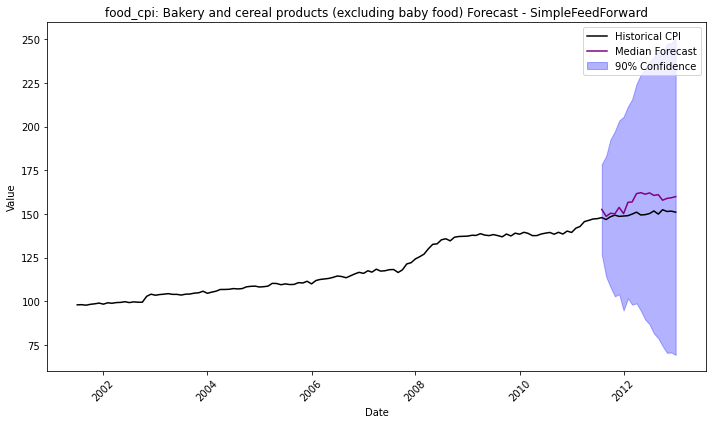

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_global_all_SimpleFeedForwardModel/random_seed_42/2012-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          32
GPU Count:          1
Memory Avail:       158.11 GB / 188.59 GB (83.8%)
Disk Space Avail:   17610.01 GB / 249006.62 GB (7.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular', 'RecursiveTabular'],
 'hyperparameters': {'SimpleFeedForwardModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': Fal

SimpleFeedForwardModel



AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-10-25 22:04:04
Excluded model types: ['DirectTabular', 'RecursiveTabular']
Models that will be trained: ['SimpleFeedForward']
Training timeseries model SimpleFeedForward. Training for up to 1799.8s of the 1799.8s of remaining time.
	-1.0165       = Validation score (-MAPE)
	87.71   s     = Training runtime
	0.12    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['SimpleFeedForward']
Total runtime: 87.86 s
Best model: SimpleFeedForward
Best model score: -1.0165
Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


****************** Summary of fit() ******************
Estimated performance of each model:
               model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SimpleFeedForward  -1.016466        0.12478          87.708782          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


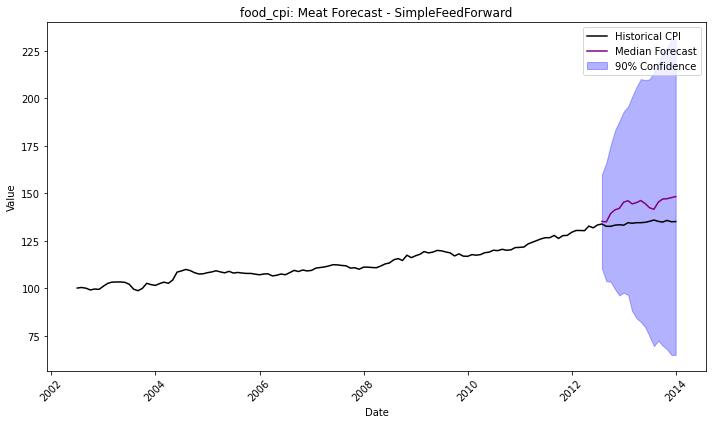

Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


****************** Summary of fit() ******************
Estimated performance of each model:
               model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SimpleFeedForward  -1.016466        0.12478          87.708782          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


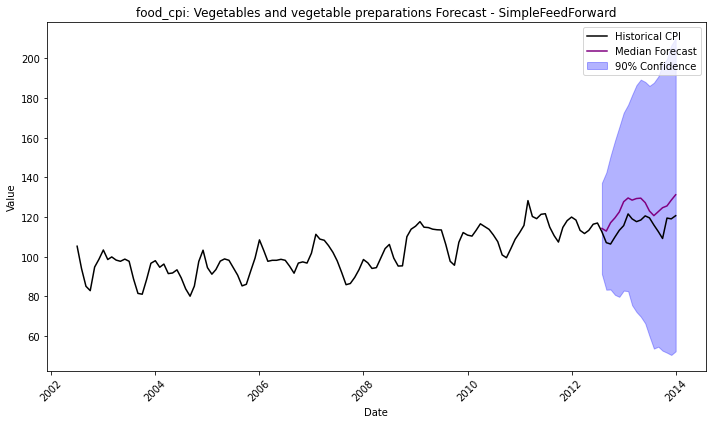

****************** Summary of fit() ******************
Estimated performance of each model:
               model  score_val  pred_time_val  fit_time_marginal  fit_order
0  SimpleFeedForward  -1.016466        0.12478          87.708782          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward
Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


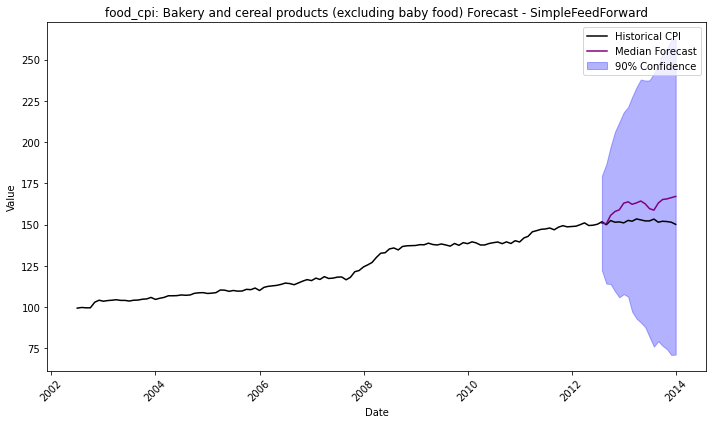

In [47]:
EXP_BASE_LIST_GLOBAL = ["ag_global_all"]


for EXP_BASE in EXP_BASE_LIST_GLOBAL:

#     EXP_MODEL_LIST = get_model_list(EXP_BASE)
    EXP_MODEL_LIST = ['TemporalFusionTransformerModel',
                 'SimpleFeedForwardModel'
                 ]
    
    print(EXP_MODEL_LIST)

    for model_type in EXP_MODEL_LIST:
        print(model_type)
        
        
        EXPERIMENT_NAME = f"{EXP_BASE}_{model_type}"

        for cutoff_date in report_sim_dates:
            forecast_output_dir, plot_output_dir, training_output_dir, model_dir = (
                create_output_directories(
                    exp_test_description,
                    start_year,
                    EXPERIMENT_NAME,
                    cutoff_date,
                    random_seed
                )
            )

            if "_covariates" in EXP_BASE:
                train_data = processor.get_autogluon_global_with_covariates_df(
                    cutoff_date
                )
            else:
                train_data = processor.get_autogluon_global_df(cutoff_date)

            predictor = fit_predictors_global(model_type, model_dir, train_data, random_seed)

            for category in target_categories:
                process_and_plot_forecasts(
                    predictor,
                    train_data,
                    category,
                    training_output_dir,
                    forecast_output_dir,
                    plot_output_dir,
                    foodprice_df,
                    cutoff_date
                )